# Train the model
## Step 0: Set training constant

In [1]:
import sagemaker
import conf

from sagemaker import get_execution_role


role = get_execution_role()
print(role)


arn:aws:iam::966911974471:role/service-role/AmazonSageMaker-ExecutionRole-20200922T113651


In [2]:
train_channel = conf.prefix + '/train'
validation_channel = conf.prefix + '/validation'
s3_train_data = 's3://{}/{}'.format(conf.bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(conf.bucket, validation_channel)

Next we define an output location in S3, where the model artifacts will be placed on completion of the training. These artifacts are the output of the algorithm's traning job.  We also get the URI to the Amazon SageMaker Object Detection docker image.  This ensures the estimator uses the correct algorithm from the current region.

In [3]:
s3_output_location = 's3://{}/{}/output'.format(conf.bucket, conf.prefix)

## Step 1: Define training hyperparameters

In [4]:
#from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker import image_uris
sess = sagemaker.Session()
#training_image = get_image_uri(sess.boto_region_name, 'object-detection', repo_version='latest')
region=sess.boto_region_name
training_image = image_uris.retrieve('object-detection',region)
print (training_image)

811284229777.dkr.ecr.us-east-1.amazonaws.com/object-detection:1


In [5]:

od_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         instance_count=1, 
                                         instance_type='ml.p3.16xlarge',
                                         volume_size = 50,
                                         max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)


In [6]:
def set_hyperparameters(num_epochs, lr_steps, num_classes, train_df):

    num_training_samples = train_df
    print('num epochs: {}, num classes: {}, num training images: {}'.format(num_epochs, num_classes, num_training_samples))

    od_model.set_hyperparameters(base_network='resnet-50',
                                 use_pretrained_model=1,
                                 num_classes=num_classes,
                                 mini_batch_size=16,
                                 epochs=num_epochs,               
                                 learning_rate=0.001, 
                                 lr_scheduler_step=lr_steps,      
                                 lr_scheduler_factor=0.1,
                                 optimizer='sgd',
                                 momentum=0.9,
                                 weight_decay=0.0005,
                                 overlap_threshold=0.5,
                                 nms_threshold=0.45,
                                 image_shape=512,
                                 label_width=350,
                                 num_training_samples=num_training_samples)
    
    
    

In [7]:
set_hyperparameters(conf.num_epochs, '33,67',conf.num_classes, conf.train_df)

num epochs: 10, num classes: 1, num training images: 9430


Now that the hyperparameters are setup, we define the data channels to be passed to the algorithm. To do this, we need to create the `sagemaker.session.s3_input` objects from our data channels. These objects are then put in a simple dictionary, which the algorithm consumes.  Note that you could add a third channel named `model` to perform incremental training (continue training from where you had left off with a prior model).

In [8]:
train_data = sagemaker.inputs.TrainingInput(s3_train_data, distribution='FullyReplicated', 
                        content_type='application/x-recordio', s3_data_type='S3Prefix')
validation_data = sagemaker.inputs.TrainingInput(s3_validation_data, distribution='FullyReplicated', 
                             content_type='application/x-recordio', s3_data_type='S3Prefix')
data_channels = {'train': train_data, 'validation': validation_data}

## Step 2: Submit training job

In [9]:
%%time
od_model.fit(inputs=data_channels, logs=True)

2020-11-26 07:27:11 Starting - Starting the training job...
2020-11-26 07:27:13 Starting - Launching requested ML instances.........
2020-11-26 07:28:57 Starting - Preparing the instances for training......
2020-11-26 07:30:09 Downloading - Downloading input data...
2020-11-26 07:30:25 Training - Downloading the training image......
2020-11-26 07:31:28 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
[11/26/2020 07:31:30 INFO 140004883121984] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'label_width': u'350', u'early_stopping_min_epochs': u'10', u'epochs': u'30', u'overlap_threshold': u'0.5', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0005', u'mini_batch_size': u'32', u'use_pretrained_model': u'0', u'freeze_layer_pattern': u'', u'lr_scheduler_step': u'', u'early_stopping': u'False', u'early_stopping_patience': u'5', u'mo

[11/26/2020 07:35:31 INFO 140004883121984] Epoch:    1, batches:    200, num_examples:   3200, 72.5 samples/sec, epoch time so far:  0:00:44.156634
[11/26/2020 07:35:54 INFO 140004883121984] Epoch:    1, batches:    300, num_examples:   4800, 72.0 samples/sec, epoch time so far:  0:01:06.649642
[11/26/2020 07:36:17 INFO 140004883121984] Epoch:    1, batches:    400, num_examples:   6400, 71.6 samples/sec, epoch time so far:  0:01:29.382622
[11/26/2020 07:36:38 INFO 140004883121984] Epoch:    1, batches:    500, num_examples:   8000, 72.0 samples/sec, epoch time so far:  0:01:51.140679
[11/26/2020 07:36:58 INFO 140004883121984] #quality_metric: host=algo-1, epoch=1, batch=589 train cross_entropy <loss>=(0.5570799104433422)
[11/26/2020 07:36:58 INFO 140004883121984] #quality_metric: host=algo-1, epoch=1, batch=589 train smooth_l1 <loss>=(0.4539318011282833)
[11/26/2020 07:36:58 INFO 140004883121984] Round of batches complete
[11/26/2020 07:36:58 INFO 140004883121984] Updated the metrics


[11/26/2020 07:45:13 INFO 140004883121984] #quality_metric: host=algo-1, epoch=4, validation mAP <score>=(0.9356644968313633)
[11/26/2020 07:45:13 INFO 140004883121984] Updating the best model with validation-mAP=0.9356644968313633
[11/26/2020 07:45:13 INFO 140004883121984] Saved checkpoint to "/opt/ml/model/model_algo_1-0000.params"
[11/26/2020 07:45:13 INFO 140004883121984] #progress_metric: host=algo-1, completed 50 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Max Records Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Reset Count": {"count": 1, "max": 5, "sum": 5.0, "min": 5}}, "EndTime": 1606

[11/26/2020 07:53:24 INFO 140004883121984] Epoch:    8, batches:    100, num_examples:   1600, 68.1 samples/sec, epoch time so far:  0:00:23.479335
[11/26/2020 07:53:46 INFO 140004883121984] Epoch:    8, batches:    200, num_examples:   3200, 70.5 samples/sec, epoch time so far:  0:00:45.405800
[11/26/2020 07:54:09 INFO 140004883121984] Epoch:    8, batches:    300, num_examples:   4800, 70.5 samples/sec, epoch time so far:  0:01:08.125744
[11/26/2020 07:54:30 INFO 140004883121984] Epoch:    8, batches:    400, num_examples:   6400, 71.5 samples/sec, epoch time so far:  0:01:29.530157
[11/26/2020 07:54:52 INFO 140004883121984] Epoch:    8, batches:    500, num_examples:   8000, 71.6 samples/sec, epoch time so far:  0:01:51.665903
[11/26/2020 07:55:12 INFO 140004883121984] #quality_metric: host=algo-1, epoch=8, batch=590 train cross_entropy <loss>=(0.35405305322866487)
[11/26/2020 07:55:12 INFO 140004883121984] #quality_metric: host=algo-1, epoch=8, batch=590 train smooth_l1 <loss>=(0.1

In [10]:
import boto3
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

client = boto3.client('logs')
BASE_LOG_NAME = '/aws/sagemaker/TrainingJobs'

def plot_object_detection_log(model, title):
    logs = client.describe_log_streams(logGroupName=BASE_LOG_NAME, logStreamNamePrefix=model._current_job_name)
    cw_log = client.get_log_events(logGroupName=BASE_LOG_NAME, logStreamName=logs['logStreams'][0]['logStreamName'])

    mAP_accs=[]
    for e in cw_log['events']:
        msg = e['message']
        if 'validation mAP <score>=' in msg:
            num_start = msg.find('(')
            num_end = msg.find(')')
            mAP = msg[num_start+1:num_end]
            mAP_accs.append(float(mAP))

    print(title)
    print('Maximum mAP: %f ' % max(mAP_accs))

    fig, ax = plt.subplots()
    plt.xlabel('Epochs')
    plt.ylabel('Mean Avg Precision (mAP)')
    val_plot,   = ax.plot(range(len(mAP_accs)),   mAP_accs,   label='mAP')
    plt.legend(handles=[val_plot])
    ax.yaxis.set_ticks(np.arange(0.0, 1.05, 0.1))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
    plt.show()

mAP tracking for job: object-detection-2020-11-26-07-27-10-908
Maximum mAP: 0.987870 


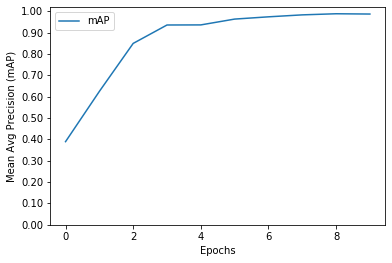

In [11]:
plot_object_detection_log(od_model, 'mAP tracking for job: ' + od_model._current_job_name)

## Step 3: Creating the Model with the training result

In [12]:
import boto3
sm = boto3.client('sagemaker')

info = sm.describe_training_job(TrainingJobName=od_model._current_job_name)
model_name=od_model._current_job_name+'-mod'
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

primary_container = {
    'Image': training_image,
    'ModelDataUrl': model_data
}

create_model_response = sm.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])
print('The Model Name is as: ' + model_name)

s3://deeplens-sziit/DEMO-ObjectDetection-birds/output/object-detection-2020-11-26-07-27-10-908/output/model.tar.gz
arn:aws:sagemaker:us-east-1:966911974471:model/object-detection-2020-11-26-07-27-10-908-mod
The Model Name is as: object-detection-2020-11-26-07-27-10-908-mod
